In [1]:
!pip install keras-tcn tensorflow==2.5.0

     |████████████████████████████████| 454.3 MB 14 kB/s 
     |████████████████████████████████| 1.2 MB 15.6 MB/s 
     |████████████████████████████████| 6.0 MB 51.6 MB/s 
     |████████████████████████████████| 4.0 MB 53.2 MB/s 
     |████████████████████████████████| 4.0 MB 23.4 MB/s 
     |████████████████████████████████| 462 kB 54.4 MB/s 
     |████████████████████████████████| 4.9 MB 17.1 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Attempting uninstall: h5py
    Found existing installatio

In [2]:
# data setup code

import numpy as np # linear algebra
np.set_printoptions(precision=3, suppress=True) # improve printing

from scipy.signal import lfilter
import scipy

import tensorflow as tf
from tensorflow.keras import layers, models, losses, metrics, Input, utils
import tensorflow_addons as tfa

from tcn import TCN, tcn_full_summary

import os
from random import choice
import re
from scipy.fft import fft

file_name_regex = re.compile("([I\d]{3})_SIG_II\.npy")

# file loader
def load_files(path):
    data = {}
    for entry in os.scandir(path):
        if entry.is_dir():
            for file in os.scandir(entry.path):
                match = file_name_regex.match(file.name)
                if match and file.is_file():
                    data[match.groups()[0]] = np.load(file.path)
    return data

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
print(scipy.__version__, np.__version__, tf.__version__)

1.5.4 1.19.5 2.5.0


In [4]:
try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

    # instantiate a distribution strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("No TPU detected; Defaulting to CPU or GPU training.")
    print("GPUs available: ", tf.config.list_physical_devices('GPU'))
    strategy = tf.distribute.get_strategy()

No TPU detected; Defaulting to CPU or GPU training.
GPUs available:  []


In [5]:
# actually load the data
data = load_files("../input/ecg-lead-2-dataset-physionet-open-access/db_npy")

In [6]:
# select the person you want the model to learn to recognise:
target = choice(list(data.keys()))
# you can also define it manually:
# target = "100"
print(target)

233


In [7]:
# prepare training and validation data
training_data, validation_data, training_labels, validation_labels = ([], [], [], [])
length = len(data.keys())
def moving_average(ar, N):
    return lfilter(np.ones(N)/N, [1], ar)

for index, (label, array) in enumerate(data.items()):
    # cut the samples at 30 minutes - makes dividing the data easier
    if array.size>230400:
        array = array[:230400]
    
    noise = np.random.normal(0,1,230400)
    array = array+noise
    norm = np.linalg.norm(array)
    array = array/norm
    array = moving_average(array, 5)
    split = np.array_split(array, 40)
    checks = [choice(list(data.keys())) if choice([True,False]) else label for i in range(len(split))]
    training_data.extend([np.reshape(fft(arr), (45, 128)) for arr in split[:20]])
    training_labels.extend([np.insert(np.zeros(length-1), index, 1)] * 20)
    validation_data.extend([np.reshape(fft(arr), (45, 128)) for arr in split[20:]])
    validation_labels.extend([np.insert(np.zeros(length-1), index, 1)]*len(checks[20:]))


In [8]:
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))

In [9]:
training_dataset

<TensorSliceDataset shapes: ((45, 128), (199,)), types: (tf.complex128, tf.float64)>

In [10]:
# shuffle and batch the dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
SHUFFLE_BUFFER_SIZE = 1000
training_dataset = training_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [11]:
# prepare 

with strategy.scope():
    
    used_metrics = [
        metrics.TruePositives(name='tp'),
        metrics.FalsePositives(name="fp"),
        metrics.TrueNegatives(name='tn'),
        metrics.FalseNegatives(name='fn'),
        metrics.CategoricalAccuracy(name='accuracy'),
    ]
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./checkpoints/checkpoint.ckpt",
                                                             save_weights_only=True,
                                                             save_best_only=True,
                                                             monitor='val_accuracy',
                                                             verbose=1)
    model = models.Sequential([
        TCN(input_shape=(45,128), kernel_size=3, use_skip_connections=True, nb_filters=64, dilations=[1,2,4,8], return_sequences=True, use_batch_norm=True, dropout_rate=0.05),
        TCN(kernel_size=3, use_skip_connections=True, nb_filters=16, dilations=[1,2,4,8], use_batch_norm=True, dropout_rate=0.05),
        layers.Dense(32, activation="linear"),
        layers.Dense(96, activation="linear"),
        layers.Dense(length, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=used_metrics)
    

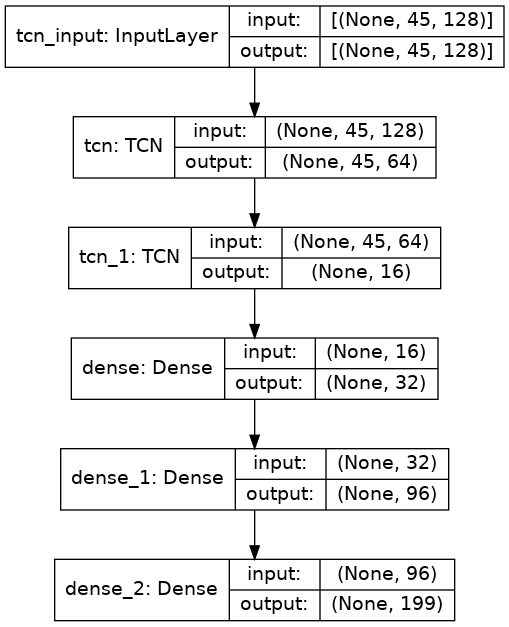

In [12]:
utils.plot_model(model, show_shapes=True)

In [13]:
epochs = 200
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[checkpoint_callback]
)

Epoch 1/200
63/63 [==============================] - 16s 154ms/step - loss: 5.3278 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 788040.0000 - fn: 3980.0000 - accuracy: 0.0063 - val_loss: 5.3036 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 788040.0000 - val_fn: 3980.0000 - val_accuracy: 0.0033

Epoch 00001: val_accuracy improved from -inf to 0.00327, saving model to ./checkpoints/checkpoint.ckpt
Epoch 2/200
63/63 [==============================] - 9s 149ms/step - loss: 5.2923 - tp: 1.0000 - fp: 0.0000e+00 - tn: 788040.0000 - fn: 3979.0000 - accuracy: 0.0131 - val_loss: 5.3383 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 788040.0000 - val_fn: 3980.0000 - val_accuracy: 0.0055

Epoch 00002: val_accuracy improved from 0.00327 to 0.00553, saving model to ./checkpoints/checkpoint.ckpt
Epoch 3/200
63/63 [==============================] - 9s 142ms/step - loss: 5.2525 - tp: 0.0000e+00 - fp: 6.0000 - tn: 788034.0000 - fn: 3980.0000 - accuracy: 0.0065 - val_loss: 5.4482 - val_tp: 0.0000e+

In [14]:
model.load_weights("./checkpoints/checkpoint.ckpt")

In [15]:
# evaluate
loss, *validation_metrics = model.evaluate(validation_dataset)

print("Loss: ", loss)
print("Accuracy: ", validation_metrics)


63/63 [==============================] - 2s 29ms/step - loss: 12.5442 - tp: 158.0000 - fp: 2562.0000 - tn: 785478.0000 - fn: 3822.0000 - accuracy: 0.0505
Loss:  12.544248580932617
Accuracy:  [158.0, 2562.0, 785478.0, 3822.0, 0.050502512603998184]


In [16]:
prediction_test = model.predict(validation_dataset)

In [17]:
#for element in prediction_test:
#    print(element)
print(element[0])

NameError: name 'element' is not defined

In [18]:
# save the model:
model.save_weights('./checkpoints/final_checkpoint.ckpt')
model.save_weights('./checkpoints/final_checkpoint.h5')
model.save('./checkpoints/model.h5')
tf.saved_model.save(model, "./model")

In [19]:
# convert to tflite
converter = tf.lite.TFLiteConverter.from_saved_model("./model")
tflite_model = converter.convert()
with open('./model.tflite', 'wb') as f:
    f.write(tflite_model)